# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from itertools import cycle, islice
from sklearn.preprocessing import StandardScaler
import arvatoutils as avt

# magic word for producing visualizations in notebook
%matplotlib inline
rnd_state = 16
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 300)
figsize = (25,15)
point_size=.01
point_border=0.001

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
azdias = pd.read_csv('../data/azdias.csv', sep=';', dtype='category', low_memory=False)
customers = pd.read_csv('../data/customers.csv', sep=';', dtype='category', low_memory=False)

### Look at the data

In [4]:
# Display basic information
customers.shape, azdias.shape

((191652, 369), (891221, 366))

In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: category(369)
memory usage: 75.5 MB


In [7]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [8]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: category(366)
memory usage: 364.2 MB


In [9]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

### Data preparation

In [10]:
# Drop the three spacial columns from the customers dataset.
special_columns = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
customers_spec = customers[special_columns]
customers.drop(special_columns, axis=1, inplace=True)

In [11]:
# Drop the user ID columns
customers = customers.drop(['LNR'], axis=1)
azdias = azdias.drop('LNR', axis=1)
customers.shape, azdias.shape

((191652, 365), (891221, 365))

In [12]:
# Find the columns, where at least 27% of data is missing
# Keep three of them (I believe those three are important for the analysis) and drop the rest
drop = avt.find_sparse_columns([customers, azdias], 0.27)
len(set(drop))

93

In [13]:
keep = ['KKK', 'MOBI_REGIO', 'REGIOTYP']
drop = [x for x in drop if x not in keep]
customers.drop(drop, axis=1, inplace=True)
azdias.drop(drop, axis=1, inplace=True)
customers.shape, azdias.shape

((191652, 275), (891221, 275))

In [14]:
missing = customers.isnull().sum().sort_values()
missing = missing[missing != 0]
# missing

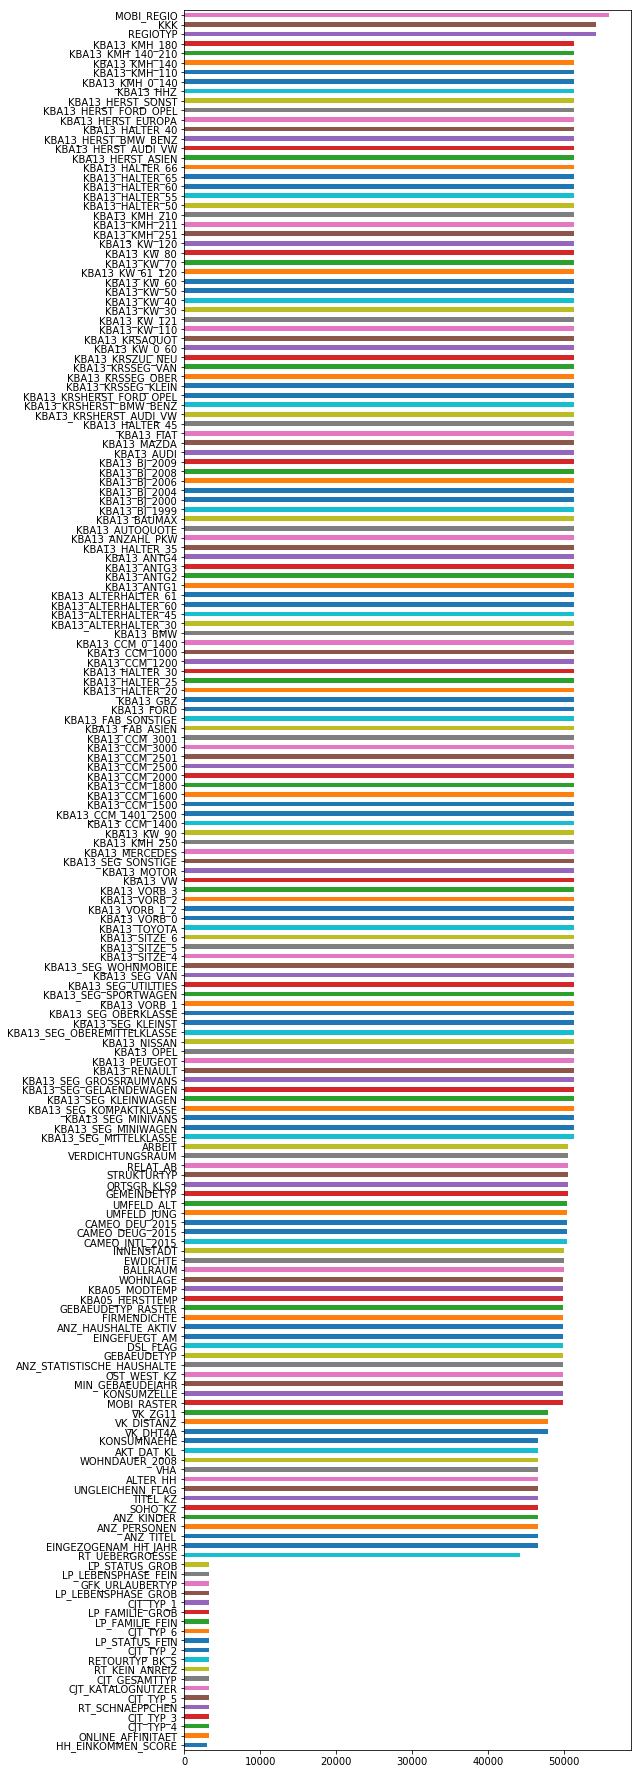

In [15]:
missing.plot(x=missing, y=missing.values, kind='barh', figsize=(8,32))

In [16]:
# Drop the columns which KBA13 and D19
avt.remove_col_by_name(customers, 'KBA13_')
avt.remove_col_by_name(azdias, 'KBA13_')
avt.remove_col_by_name(customers, 'D19_')
avt.remove_col_by_name(azdias, 'D19_')

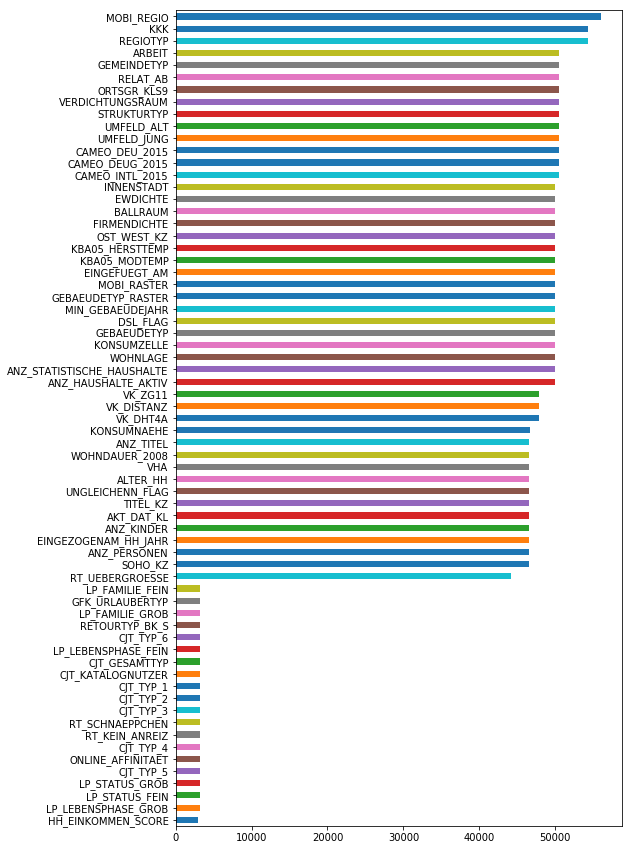

In [17]:
missing = customers.isnull().sum().sort_values()
missing = missing[missing != 0]
missing.plot(x=missing, y=missing.values, kind='barh', figsize=(8,15))

In [18]:
# Drop some more columns
manual_drop = ['AGER_TYP', 'AKT_DAT_KL','ANZ_STATISTISCHE_HAUSHALTE', 'ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ARBEIT', 'DSL_FLAG', 'EINGEFUEGT_AM',
               'EINGEZOGENAM_HH_JAHR', 'FIRMENDICHTE', 'GEBURTSJAHR', 'GEMEINDETYP', 'KBA05_HERSTTEMP', 'KBA05_MODTEMP',
              'KONSUMZELLE', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'MOBI_RASTER',
              'ORTSGR_KLS9', 'OST_WEST_KZ', 'RELAT_AB', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ',
              'STRUKTURTYP', 'TITEL_KZ', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VERS_TYP',
              'VHA', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'WOHNDAUER_2008']
customers.drop(manual_drop, axis=1, inplace=True)
azdias.drop(manual_drop, axis=1, inplace=True)

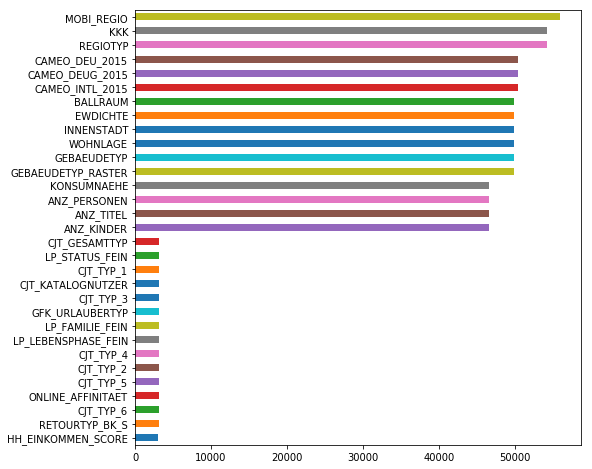

In [19]:
missing = customers.isnull().sum().sort_values()
missing = missing[missing != 0]
missing.plot(x=missing, y=missing.values, kind='barh', figsize=(8,8))

In [20]:
customers.shape, azdias.shape

((191652, 61), (891221, 61))

In [21]:
# Take a look at the values representing coded missing data. E.g. feature HEALTH_TYP value -1 means 'unknown'.
for col in customers.columns:
    print('Column ---------- ', col)
    print(customers[col].value_counts())

Column ----------  ANZ_KINDER
0.0    132284
1.0      7443
2.0      3967
3.0      1104
4.0       204
5.0        46
6.0         6
8.0         1
7.0         1
Name: ANZ_KINDER, dtype: int64
Column ----------  ANZ_PERSONEN
2.0     43780
1.0     40929
3.0     27231
4.0     16101
0.0      7146
5.0      6482
6.0      2332
7.0       716
8.0       222
9.0        65
10.0       22
11.0       12
12.0        9
14.0        3
13.0        2
21.0        2
15.0        1
16.0        1
Name: ANZ_PERSONEN, dtype: int64
Column ----------  ANZ_TITEL
0.0    142316
1.0      2533
2.0       198
3.0         8
5.0         1
Name: ANZ_TITEL, dtype: int64
Column ----------  BALLRAUM
6.0    48075
1.0    21097
2.0    20117
7.0    17873
3.0    13240
4.0    11538
5.0     9753
Name: BALLRAUM, dtype: int64
Column ----------  CAMEO_DEU_2015
2D    11208
6B     9634
4C     9053
3D     8085
4A     7507
3C     6628
1D     5880
2C     5076
5D     4546
8A     4252
1A     4198
7A     4109
8B     3790
2A     3715
2B     3485
7B   

In [22]:
# Drop those columns, where we identified significant amount of coded missing/unknown data.
drop_more = ['HEALTH_TYP', 'KOMBIALTER', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP']
customers.drop(drop_more, axis=1, inplace=True)
azdias.drop(drop_more, axis=1, inplace=True)
customers.shape, azdias.shape

((191652, 56), (891221, 56))

In [28]:
customers[customers.LP_FAMILIE_FEIN == '0.0'].shape

(0, 56)

In [27]:
azdias[azdias.KKK == '0.0'].shape

(0, 56)

In [32]:
azdias[azdias.LP_LEBENSPHASE_FEIN == '0.0'].shape

(92778, 56)

In [33]:
# To continue with the rest of the coded missing/unknown data, we drop the rows for the rest.
customers.drop(customers[customers.CAMEO_DEU_2015 == 'XX'].index, inplace=True)
customers.drop(customers[customers.CAMEO_DEUG_2015 == 'X'].index, inplace=True)
customers.drop(customers[customers.CAMEO_INTL_2015 == 'XX'].index, inplace=True)
customers.drop(customers[customers.KKK == '0'].index, inplace=True)
customers.drop(customers[customers.LP_FAMILIE_FEIN == '0'].index, inplace=True)
customers.drop(customers[customers.LP_LEBENSPHASE_FEIN == '0'].index, inplace=True)
customers.drop(customers[customers.MOBI_REGIO == '6'].index, inplace=True)
customers.drop(customers[customers.REGIOTYP == '0'].index, inplace=True)
azdias.drop(azdias[azdias.CAMEO_DEU_2015 == 'XX'].index, inplace=True)
azdias.drop(azdias[azdias.CAMEO_DEUG_2015 == 'X'].index, inplace=True)
azdias.drop(azdias[azdias.CAMEO_INTL_2015 == 'XX'].index, inplace=True)
azdias.drop(azdias[azdias.KKK == '0'].index, inplace=True)
azdias.drop(azdias[azdias.LP_FAMILIE_FEIN == '0'].index, inplace=True)
azdias.drop(azdias[azdias.LP_LEBENSPHASE_FEIN == '0'].index, inplace=True)
azdias.drop(azdias[azdias.MOBI_REGIO == '6'].index, inplace=True)
azdias.drop(azdias[azdias.REGIOTYP == '0'].index, inplace=True)

In [34]:
customers.shape, azdias.shape

((191526, 56), (890848, 56))

In [ ]:
customers[customers.KKK == "0.0"].shape

In [ ]:
azdias[azdias.KKK == 0].shape

In [35]:
# Drop rows containing missing values
customers.dropna(inplace=True)
azdias.dropna(inplace=True)
customers.shape, azdias.shape

((131104, 56), (741560, 56))

In [36]:
cust_before_dummies = customers
azdias_before_dummies = azdias

In [37]:
# Create category codes
customers, azdias = avt.create_cat_codes(customers, azdias)

In [38]:
# Find and later drop features with high correlation
feat_rel_cust = avt.feat_relevance(customers)
feat_rel_cust.sort_values('score')

,feature,score
25,GFK_URLAUBERTYP,0.251373
30,KONSUMNAEHE,0.379515
28,INNENSTADT,0.440536
40,SEMIO_FAM,0.460367
3,BALLRAUM,0.486148
34,MOBI_REGIO,0.488803
27,HH_EINKOMMEN_SCORE,0.507353
49,SEMIO_SOZ,0.510953
35,ONLINE_AFFINITAET,0.518855
52,WOHNLAGE,0.540456


In [39]:
new_cols = feat_rel_cust['feature'][feat_rel_cust['score'] < 0.85]

In [40]:
customers_reduced = customers[new_cols]
customers_reduced.shape

(131104, 35)

In [41]:
azdias_reduced = azdias[customers_reduced.columns]

In [42]:
customers_reduced.shape, azdias_reduced.shape

((131104, 35), (741560, 35))

In [43]:
nominal_variables = ['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_2', 'CJT_TYP_6',
                     'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'ZABEOTYP']
ordinal_varialbes = ['ANZ_PERSONEN', 'BALLRAUM', 'EWDICHTE', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER',
                     'FINANZ_MINIMALIST', 'FINANZ_UNAUFFAELLIGER', 'GEBAEUDETYP_RASTER',
                     'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KONSUMNAEHE', 'MOBI_REGIO',
                     'ONLINE_AFFINITAET', 'REGIOTYP', 'RETOURTYP_BK_S', 'SEMIO_FAM', 'SEMIO_KRIT',
                     'SEMIO_KULT', 'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL',
                     'SEMIO_SOZ', 'SEMIO_VERT', 'WOHNLAGE']

In [44]:
customers_reduced, azdias_reduced = avt.create_dummies(customers_reduced, azdias_reduced, nominal_variables)

In [45]:
customers_reduced.shape, azdias_reduced.shape

((131104, 163), (741560, 163))

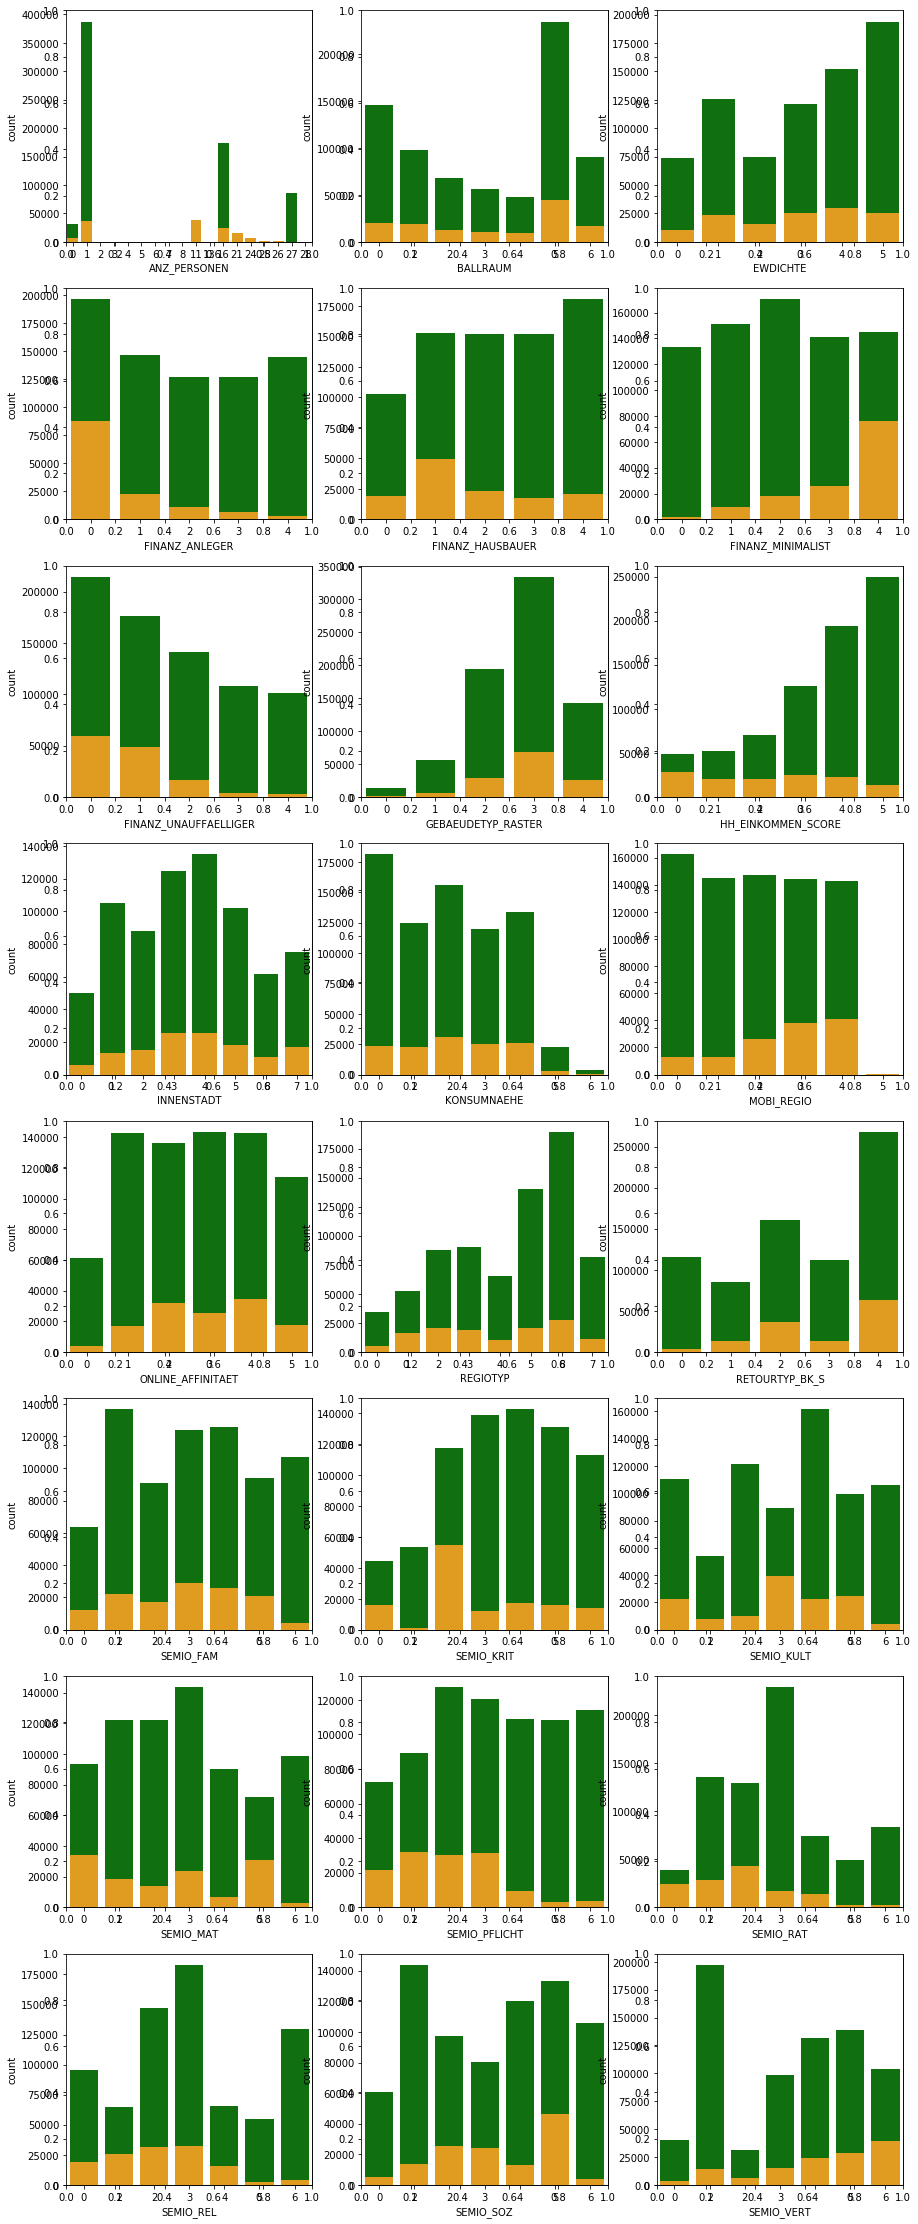

In [46]:
fig1, ax = plt.subplots(nrows=8, ncols=3, figsize=(15, 40))
col = 0
for i in range(8):
    for j in range(3):
        if col < customers_reduced.shape[1]:
            col = i*3+j+1
            ax = fig1.add_subplot(8, 3, col)
            sns.countplot(azdias_reduced.iloc[:,col-1], color='green')
            sns.countplot(customers_reduced.iloc[:,col-1], color='orange')

In [47]:
scaler = StandardScaler()
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_reduced), columns=customers_reduced.columns)
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_reduced), columns=azdias_reduced.columns)

C:\Anaconda\envs\aind-dog\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int8, uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\envs\aind-dog\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int8, uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda\envs\aind-dog\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int8, uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\envs\aind-dog\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int8, uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [48]:
customers_scaled.to_pickle('customers_clean_data.pkl')
azdias_scaled.to_pickle('azdias_clean_data.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [49]:
# Read the cleaned data sets.
df_cust = pd.read_pickle('customers_clean_data.pkl')
df_azdias = pd.read_pickle('azdias_clean_data.pkl')
df_cust.shape, df_azdias.shape

((131104, 163), (741560, 163))

In [50]:
df_cust.describe()

,ANZ_PERSONEN,BALLRAUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_UNAUFFAELLIGER,GEBAEUDETYP_RASTER,HH_EINKOMMEN_SCORE,INNENSTADT,KONSUMNAEHE,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,RETOURTYP_BK_S,SEMIO_FAM,SEMIO_KRIT,SEMIO_KULT,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_VERT,WOHNLAGE,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_INTL_2015_0,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2,CAMEO_INTL_2015_3,CAMEO_INTL_2015_4,CAMEO_INTL_2015_5,CAMEO_INTL_2015_6,CAMEO_INTL_2015_7,CAMEO_INTL_2015_8,CAMEO_INTL_2015_9,CAMEO_INTL_2015_10,CAMEO_INTL_2015_11,CAMEO_INTL_2015_12,CAMEO_INTL_2015_13,CAMEO_INTL_2015_14,CAMEO_INTL_2015_15,CAMEO_INTL_2015_16,CAMEO_INTL_2015_17,CAMEO_INTL_2015_18,CAMEO_INTL_2015_19,CAMEO_INTL_2015_20,CAMEO_INTL_2015_21,CAMEO_INTL_2015_22,CAMEO_INTL_2015_23,CAMEO_INTL_2015_24,CAMEO_INTL_2015_25,CAMEO_INTL_2015_26,CAMEO_INTL_2015_27,CAMEO_INTL_2015_28,CAMEO_INTL_2015_29,CAMEO_INTL_2015_30,CAMEO_INTL_2015_31,CAMEO_INTL_2015_32,CAMEO_INTL_2015_33,CAMEO_INTL_2015_34,CAMEO_INTL_2015_35,CAMEO_INTL_2015_36,CAMEO_INTL_2015_37,CAMEO_INTL_2015_38,CAMEO_INTL_2015_39,CAMEO_INTL_2015_40,CAMEO_INTL_2015_41,CJT_GESAMTTYP_0,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_KATALOGNUTZER_0,CJT_KATALOGNUTZER_1,CJT_KATALOGNUTZER_2,CJT_KATALOGNUTZER_3,CJT_KATALOGNUTZER_4,CJT_TYP_2_0,CJT_TYP_2_1,CJT_TYP_2_2,CJT_TYP_2_3,CJT_TYP_2_4,CJT_TYP_6_0,CJT_TYP_6_1,CJT_TYP_6_2,CJT_TYP_6_3,CJT_TYP_6_4,FINANZTYP_0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,GEBAEUDETYP_0,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,GFK_URLAUBERTYP_0,GFK_URLAUBERTYP_1,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_4,GFK_URLAUBERTYP_5,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,ZABEOTYP_0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5
count,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.311040e+05,1.31

In [51]:
df_azdias.describe()

,ANZ_PERSONEN,BALLRAUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_UNAUFFAELLIGER,GEBAEUDETYP_RASTER,HH_EINKOMMEN_SCORE,INNENSTADT,KONSUMNAEHE,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,RETOURTYP_BK_S,SEMIO_FAM,SEMIO_KRIT,SEMIO_KULT,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_VERT,WOHNLAGE,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_INTL_2015_0,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2,CAMEO_INTL_2015_3,CAMEO_INTL_2015_4,CAMEO_INTL_2015_5,CAMEO_INTL_2015_6,CAMEO_INTL_2015_7,CAMEO_INTL_2015_8,CAMEO_INTL_2015_9,CAMEO_INTL_2015_10,CAMEO_INTL_2015_11,CAMEO_INTL_2015_12,CAMEO_INTL_2015_13,CAMEO_INTL_2015_14,CAMEO_INTL_2015_15,CAMEO_INTL_2015_16,CAMEO_INTL_2015_17,CAMEO_INTL_2015_18,CAMEO_INTL_2015_19,CAMEO_INTL_2015_20,CAMEO_INTL_2015_21,CAMEO_INTL_2015_22,CAMEO_INTL_2015_23,CAMEO_INTL_2015_24,CAMEO_INTL_2015_25,CAMEO_INTL_2015_26,CAMEO_INTL_2015_27,CAMEO_INTL_2015_28,CAMEO_INTL_2015_29,CAMEO_INTL_2015_30,CAMEO_INTL_2015_31,CAMEO_INTL_2015_32,CAMEO_INTL_2015_33,CAMEO_INTL_2015_34,CAMEO_INTL_2015_35,CAMEO_INTL_2015_36,CAMEO_INTL_2015_37,CAMEO_INTL_2015_38,CAMEO_INTL_2015_39,CAMEO_INTL_2015_40,CAMEO_INTL_2015_41,CJT_GESAMTTYP_0,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_KATALOGNUTZER_0,CJT_KATALOGNUTZER_1,CJT_KATALOGNUTZER_2,CJT_KATALOGNUTZER_3,CJT_KATALOGNUTZER_4,CJT_TYP_2_0,CJT_TYP_2_1,CJT_TYP_2_2,CJT_TYP_2_3,CJT_TYP_2_4,CJT_TYP_6_0,CJT_TYP_6_1,CJT_TYP_6_2,CJT_TYP_6_3,CJT_TYP_6_4,FINANZTYP_0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,GEBAEUDETYP_0,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,GFK_URLAUBERTYP_0,GFK_URLAUBERTYP_1,GFK_URLAUBERTYP_2,GFK_URLAUBERTYP_3,GFK_URLAUBERTYP_4,GFK_URLAUBERTYP_5,GFK_URLAUBERTYP_6,GFK_URLAUBERTYP_7,GFK_URLAUBERTYP_8,GFK_URLAUBERTYP_9,GFK_URLAUBERTYP_10,GFK_URLAUBERTYP_11,ZABEOTYP_0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5
count,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,741560.000000,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.415600e+05,7.4

In [52]:
pca = PCA(n_components=163, random_state=rnd_state)
pca = pca.fit(pd.concat([df_cust, df_azdias]))

In [53]:
pca_res = avt.pca_results(pd.concat([df_cust, df_azdias]), pca)

In [54]:
print (pca_res['Explained Variance'].cumsum())

Dimension 1      0.0506
Dimension 2      0.0903
Dimension 3      0.1176
Dimension 4      0.1360
Dimension 5      0.1515
Dimension 6      0.1653
Dimension 7      0.1784
Dimension 8      0.1914
Dimension 9      0.2043
Dimension 10     0.2171
Dimension 11     0.2298
Dimension 12     0.2424
Dimension 13     0.2550
Dimension 14     0.2676
Dimension 15     0.2801
Dimension 16     0.2926
Dimension 17     0.3051
Dimension 18     0.3176
Dimension 19     0.3300
Dimension 20     0.3424
Dimension 21     0.3548
Dimension 22     0.3672
Dimension 23     0.3795
Dimension 24     0.3904
Dimension 25     0.4008
Dimension 26     0.4110
Dimension 27     0.4206
Dimension 28     0.4301
Dimension 29     0.4389
Dimension 30     0.4474
Dimension 31     0.4558
Dimension 32     0.4637
Dimension 33     0.4715
Dimension 34     0.4791
Dimension 35     0.4866
Dimension 36     0.4938
Dimension 37     0.5009
Dimension 38     0.5080
Dimension 39     0.5150
Dimension 40     0.5219
Dimension 41     0.5288
Dimension 42    

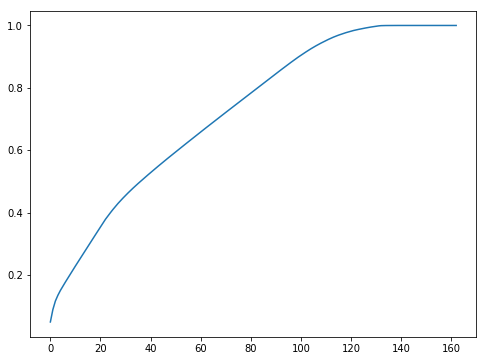

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
g1 = ax.plot(np.arange(len(pca_res)),pca_res['Explained Variance'].cumsum())
plt.show()

In [56]:
pca = PCA(n_components=110, random_state=rnd_state)
pca = pca.fit(pd.concat([df_cust, df_azdias]))

In [57]:
pca_res2 = avt.pca_results(pd.concat([df_cust, df_azdias]), pca)

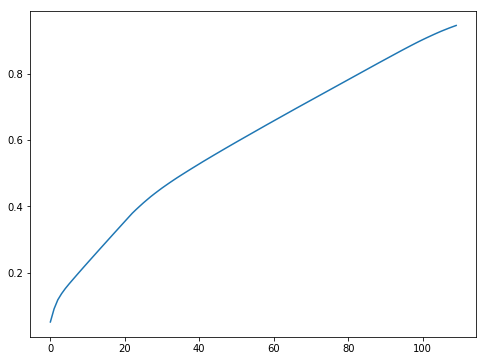

In [58]:
fig, ax = plt.subplots(figsize=(8,6))
g1 = ax.plot(np.arange(len(pca_res2)),pca_res2['Explained Variance'].cumsum())
plt.show()

In [59]:
reduced_data_cust = pd.DataFrame(pca.transform(df_cust))
reduced_data_az = pd.DataFrame(pca.transform(df_azdias))

Investigate the first two principal components

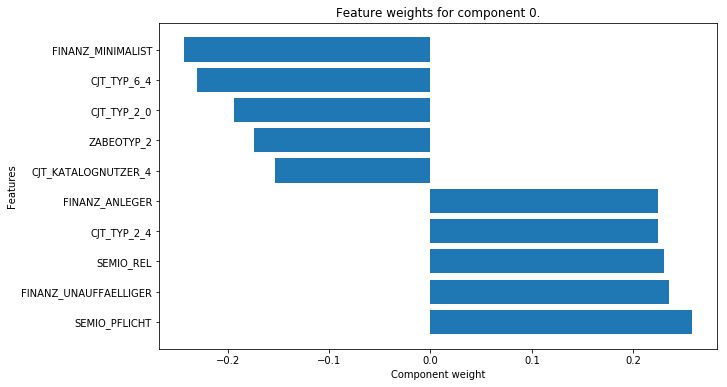

In [60]:
feat_w_0 = avt.feat_weights(pca, 0, 5, df_cust.columns)

In the first principal component the most dominant features are SEMIO_PFLICHT, FINANZ_UNAUFFAELLIGER and SEMIO_REL, while the least dominant features are FINANZ_MINIMALIST, CJT_TYP_6_4 and CJT_TYP_2_0.

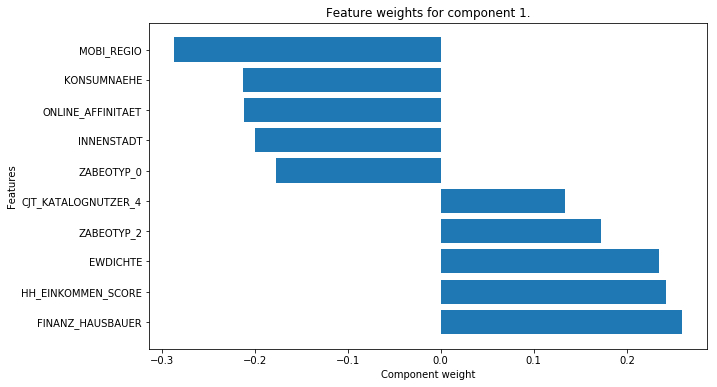

In [61]:
feat_w_1 = avt.feat_weights(pca, 1, 5, df_cust.columns)

In the second principal component the most dominant features are FINANZ_HAUSBAUER. HH_EINKOMMEN_SCORE and EWDICHTE, while the least dominant features are MOBI_REGIO, KONSUMNAEHE and ONLINE_AFFINITAET.

In [62]:
# Takes very long to run with batch_size = 30000 as original
batch_size = 5000
scores_az = []
centers = list(range(1, 80, 1))
for center in centers:
    scores_az.append(avt.get_kmeans_score(reduced_data_az, center, batch_size))

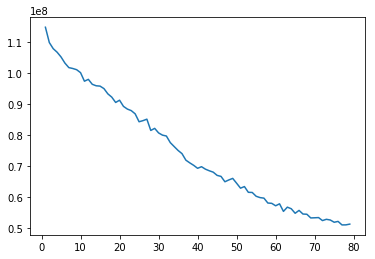

In [63]:
plt.plot(centers, scores_az)

In [64]:
# Let the number of clusters be 45.
num_clusters = 45

In [65]:
# Fit KMeans on the general population
kmeans = KMeans(n_clusters=num_clusters, random_state=rnd_state, n_jobs=31)
kmeans.fit(reduced_data_az)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=45, n_init=10, n_jobs=31, precompute_distances='auto',
    random_state=16, tol=0.0001, verbose=0)

In [66]:
# Calculate clusters for both datasets and add them as new columns
clusters_azdias = kmeans.predict(reduced_data_az)
clusters_cust = kmeans.predict(reduced_data_cust)
reduced_data_az['cluster_a'] = clusters_azdias
reduced_data_cust['cluster_c'] = clusters_cust

In [67]:
# Count cluster labels and create a new data frame.
# Then calculate the proportions of labels to the populations of customers and azdias.
# Finally, determine the difference of proportions.
# We deduct azdias values from customers, so positive numbers will indicate over-represented values in customers set,
# while negative values indicates under-represented clusters in the customers data set.
count_cluster_az = pd.DataFrame(reduced_data_az.cluster_a.value_counts())
count_cluster_cust = pd.DataFrame(reduced_data_cust.cluster_c.value_counts())
df_clust_count = pd.merge(count_cluster_az, count_cluster_cust, how='outer', left_index=True, right_index=True)
df_clust_count['cluster_a'] = df_clust_count['cluster_a'].apply(lambda x: 100*x/df_azdias.shape[0])
df_clust_count['cluster_c'] = df_clust_count['cluster_c'].apply(lambda x: 100*x/df_cust.shape[0])
df_clust_count['diff'] = df_clust_count['cluster_c']-df_clust_count['cluster_a']

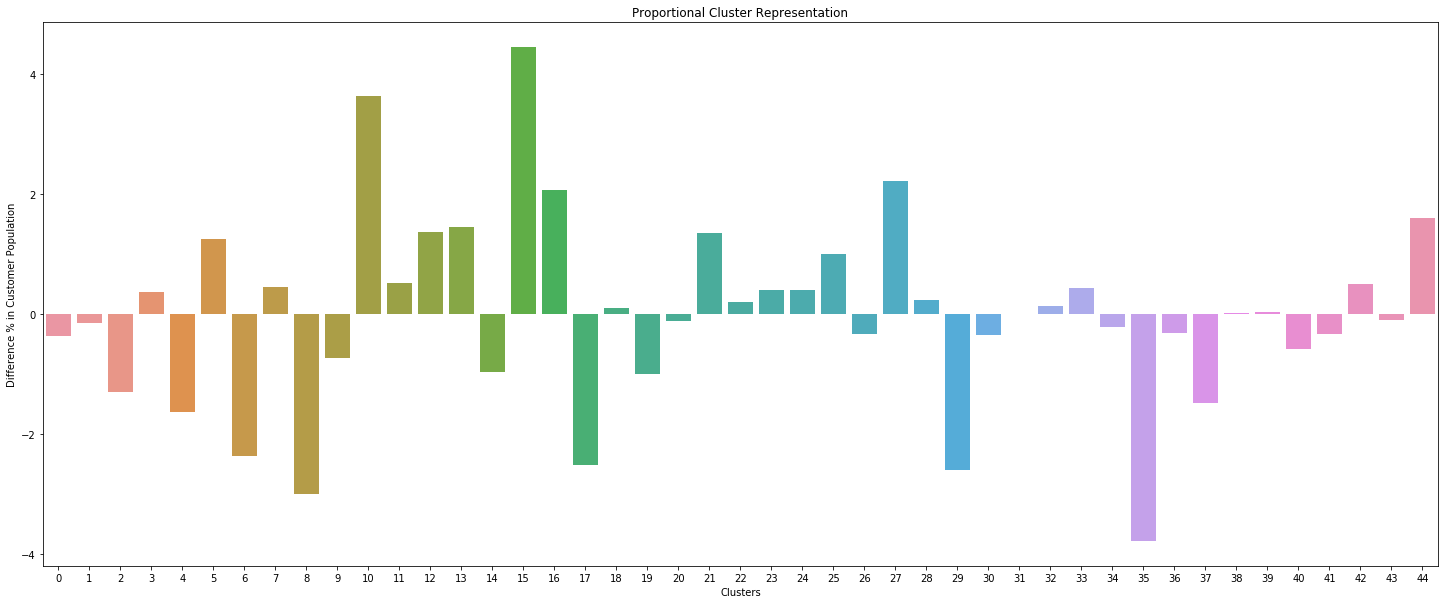

In [68]:
# Visualize the differences in the proportion.
# Positive values means that the cluster is over represented in the customer dataset,
# negative means the cluster is under represented in the customer dataset.
fig, ax = plt.subplots(figsize=(25,10))
ax.set_xlabel('Clusters')
ax.set_ylabel('Difference % in Customer Population')
ax.set_title('Proportional Cluster Representation')
g1 = sns.barplot(df_clust_count.index, df_clust_count['diff'])
ax.set_ylabel('Difference % in Customer Population')
plt.show()

In [69]:
frame = df_clust_count.sort_values(by='diff', ascending=False)
di = pd.concat([frame.head(5), frame.tail(5)])

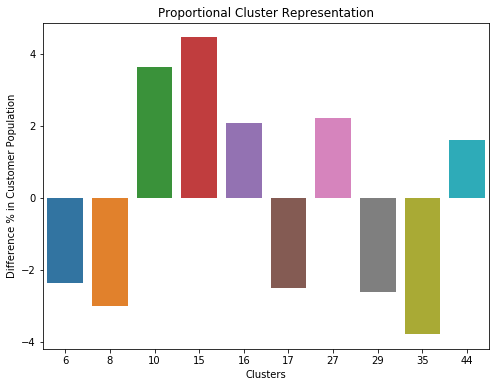

In [70]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('Clusters')
ax.set_title('Proportional Cluster Representation')
g1 = sns.barplot(di.index, di['diff'])
ax.set_ylabel('Difference % in Customer Population')
plt.show()

Labels 15, 10, 27, 16, 44 dominate in the customer data set and 35, 8, 29, 17, 6 in the general population.
Let's examine the most dominant in the customer set (label 15) and in the general population (label 35).

In [71]:
# Let's transform back the components to the original features and scale back to the original values
inverse = pd.DataFrame(pca.inverse_transform(kmeans.cluster_centers_), columns=df_cust.columns)
result = pd.DataFrame(scaler.inverse_transform(inverse), columns=inverse.columns)

In [72]:
# Narrow down the result to the most prominent diferences between customers and general population
result = result.T[result.T.std(axis=1) > 0.7]
result.loc[:,[10,15,8,35]]

,10,15,8,35
ANZ_PERSONEN,8.021753,9.179103,4.628145,5.452272
EWDICHTE,2.772742,2.981046,4.063948,3.892513
FINANZ_HAUSBAUER,1.458311,1.190304,3.051577,2.827937
HH_EINKOMMEN_SCORE,1.792591,0.834837,4.877264,4.725446
INNENSTADT,3.656879,3.440750,2.308934,2.770426
KONSUMNAEHE,2.637914,2.660003,1.320120,1.080632
MOBI_REGIO,3.098011,3.522333,0.571395,0.920146
REGIOTYP,3.138943,2.307672,4.198080,5.344244


### Customers (10 and 15):
Home owners with low mobility (rarely moving house); high income; live further away from city centers and in less densly populated areas.
### General Population (8 and 35):
Not typical home owners, moving a lot; lower income; live closer to city center in densly populated areas.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype='category', low_memory=False )

In [ ]:
mailout_train = pd.read_pickle('../data/mailout_train.pkl')
mailout_test = pd.read_pickle('../data/mailout_test.pkl')

In [ ]:
mailout_train.dtypes

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')